In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pydrake.all import (DiagramBuilder, LinearQuadraticRegulator,
                         LinearSystem, LogVectorOutput, PiecewisePolynomial,
                         Simulator, TrajectorySource)
from pydrake.solvers.mathematicalprogram import MathematicalProgram, Solve

np.random.seed(0)


# Linear System Identification

In this notebook, you will test different objective functions in linear system identification. Consider a discrete-time linear system of the form

$$x[n+1] = Ax[n]+Bu[n]$$
where $x[n]\in\mathbf{R}^p$ and $u[n]\in\mathbf{R}^q$ are state and control at step $n$.
The system matrix $A\in\mathbf{R}^{p\times p}$ and $B\in\mathbf{R}^{p\times q}$ are unknown parameters of the model, and your task is to identify the parameters given a simulated trajectory.

Let's first define a test system:

In [2]:
A = np.array([[0.8, -0.1, 0.0, 0.0], 
              [0., 0.2, 0.0, 0.1], 
              [0., -0.1, 1.0001, 0.0], 
              [0., 0.2, 0.0, 0.1]])

B = np.array([[0.0], [-0.02], [0.01], [-0.02]])
C = np.identity(4)
D = np.zeros((4,1))

Let's run a simulation to obtain the trajectory data. We add noise to the state representing measurement noise.

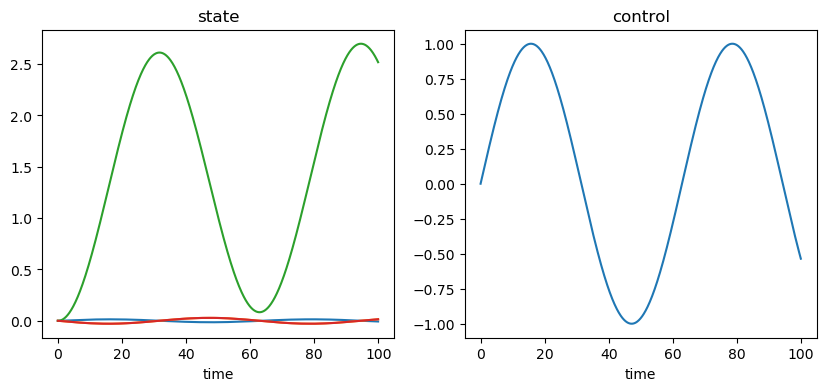

In [3]:
def generate_data(A, B, C, D, noise_level = 1e-5):
    # Define a Linear system
    sys = LinearSystem(A, B, C, D, time_period = 0.1)

    ts = np.arange(0, 100, 0.1)
    utraj = PiecewisePolynomial.CubicShapePreserving(ts, np.sin(0.1*ts).reshape((1,-1)))

    builder = DiagramBuilder()
    plant = builder.AddSystem(sys)

    usys = builder.AddSystem(TrajectorySource(utraj)) 
    builder.Connect(usys.get_output_port(), plant.get_input_port())

    logger = LogVectorOutput(plant.get_output_port(), builder)
    diagram = builder.Build()

    simulator = Simulator(diagram)
    simulator.AdvanceTo(ts[-1])

    log = logger.FindLog(simulator.get_context())
    t = log.sample_times()
    U = utraj.vector_values(log.sample_times())
    X = log.data()
    X = X + np.random.normal(size = X.shape)*noise_level

    return t, U, X
        

t, U, X = generate_data(A, B, C, D)


fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(t, X.T)
ax[1].plot(t, U.T)
ax[0].set_title("state")
ax[1].set_title("control")
ax[0].set_xlabel("time")
ax[1].set_xlabel("time")
plt.show()

The output of the simulation gives the data matrices in the following format:

$$X=\begin{bmatrix} \lvert && \lvert && && \lvert \\ x[0] && x[1] && \dots && x[N] \\ \lvert && \lvert && && \lvert \end{bmatrix}$$


$$U=\begin{bmatrix} \lvert && \lvert && && \lvert \\ u[0] && u[1] && \dots && u[N] \\ \lvert && \lvert && && \lvert \end{bmatrix}.$$

Using the simulated data, you will implement regression algorithms to identify the system model.

(a) Identify the model by solving the following optimization problem: 

$$\min_{A, B}\sum_{n=0}^{N-1}\lVert x[n+1] - Ax[n] -Bu[n] \rVert_2^2$$

The function should output the matrices $A$ and $B$ that are the solutions to the above optimization problem.

In [4]:
def sysid_2norm(X, U):
    n = X.shape[0]
    m = U.shape[0]
    A = np.zeros((n,n))
    B = np.zeros((n,m))
    ######### Put your Solution here ############
    N = X.shape[1]
    prog = MathematicalProgram()      
    var_A = prog.NewContinuousVariables(n, n, 'A')
    var_B = prog.NewContinuousVariables(n, m, 'B')
    # TODO: vectorized
    for k in range(N-1):
        res = X[:, k + 1] - var_A.dot(X[:, k]) - var_B.dot(U[:, k])
        prog.AddCost(res.dot(res))
    result = Solve(prog)
    A = result.GetSolution(var_A)
    B = result.GetSolution(var_B).reshape((4,1))
    ##############################################
    return A, B

Ahat_2norm, Bhat_2norm = sysid_2norm(X, U)

print("A = ")
print(A)
print("Â = ")
print(Ahat_2norm)
print("")
print("B = ")
print(B)
print("B̂ = ")
print(Bhat_2norm)
print("")

res = Ahat_2norm @ X[:,:-1] + Bhat_2norm @ U[:,:-1] - X[:,1:]
print(f'residual (2-norm): {np.sum(res**2)}')
print(f'residual (inf-norm): {np.sum(np.max(np.abs(res), axis = 0))}')
print(f'residual (1-norm): {np.sum(np.abs(res))}')

A = 
[[ 0.8    -0.1     0.      0.    ]
 [ 0.      0.2     0.      0.1   ]
 [ 0.     -0.1     1.0001  0.    ]
 [ 0.      0.2     0.      0.1   ]]
Â = 
[[ 7.57454891e-01 -9.22363071e-02  3.36980613e-08 -1.02486353e-01]
 [-1.98915869e-02  1.18818219e-01  1.08504529e-07  1.37653216e-01]
 [ 1.00179597e-02 -3.63411889e-02  1.00009999e+00 -4.12799240e-02]
 [-3.60693424e-02  1.00068247e-01 -6.45460576e-09  1.19247999e-01]]

B = 
[[ 0.  ]
 [-0.02]
 [ 0.01]
 [-0.02]]
B̂ = 
[[-0.00210014]
 [-0.02096008]
 [ 0.01049661]
 [-0.02179189]]

residual (2-norm): 5.318435644416061e-07
residual (inf-norm): 0.016888941295181446
residual (1-norm): 0.03672262878596258


(b) Identify the model by solving the following optimization problem: 

$$\min_{A, B}\sum_{n=0}^{N-1}\lVert x[n+1] - Ax[n] -Bu[n] \rVert_{\infty}.$$

where $L\infty$ norm of a vector is defined as

$$\lVert x \rVert_\infty = \max_{1\leq i\leq p}\lvert x_i\rvert.$$
Implement the following function that outputs the matrices $A$ and $B$ that are the solutions to the above optimization problem.


In [5]:
def sysid_infnorm(X, U):
    n = X.shape[0]
    m = U.shape[0]
    A = np.zeros((n,n))
    B = np.zeros((n,m))
    ######### Put your Solution here ############
    
    N = X.shape[1]
    prog = MathematicalProgram()      
    var_A = prog.NewContinuousVariables(n, n, 'A')
    var_B = prog.NewContinuousVariables(n, m, 'B')
    s = prog.NewContinuousVariables(N - 1)
    # TODO: vectorized
    for k in range(N - 1):
        res = X[:, k + 1] - var_A.dot(X[:, k]) - var_B.dot(U[:, k])
        for j in range(n):
            prog.AddLinearConstraint(res[j] <= s[k])
            prog.AddLinearConstraint(res[j] >= -s[k])
        prog.AddCost(s[k])
    
    result = Solve(prog)
    obj_value = result.get_optimal_cost()
    A = result.GetSolution(var_A)
    B = result.GetSolution(var_B).reshape((4,1))

    ##############################################
    return A, B, obj_value

Ahat_infnorm, Bhat_infnorm, obj_infnorm = sysid_infnorm(X, U)

print("A = ")
print(A)
print("Â = ")
print(Ahat_infnorm)
print("")
print("B = ")
print(B)
print("B̂ = ")
print(Bhat_infnorm)
print("")

res = Ahat_infnorm @ X[:,:-1] + Bhat_infnorm @ U[:,:-1] - X[:,1:]
print(f'residual (2-norm): {np.sum(res**2)}')
print(f'residual (inf-norm): {np.sum(np.max(np.abs(res), axis = 0))}')
print(f'residual (1-norm): {np.sum(np.abs(res))}')

A = 
[[ 0.8    -0.1     0.      0.    ]
 [ 0.      0.2     0.      0.1   ]
 [ 0.     -0.1     1.0001  0.    ]
 [ 0.      0.2     0.      0.1   ]]
Â = 
[[ 7.56283368e-01 -6.88513318e-02 -2.27218963e-07 -1.27476375e-01]
 [-4.15440741e-02  2.22313723e-02  2.30722385e-07  1.85173511e-01]
 [ 3.73294488e-02  8.58082354e-03  1.00009996e+00 -2.65859207e-02]
 [-6.35206116e-02 -7.78925045e-03  3.14230795e-07  1.65952000e-01]]

B = 
[[ 0.  ]
 [-0.02]
 [ 0.01]
 [-0.02]]
B̂ = 
[[-0.00212917]
 [-0.02205334]
 [ 0.01181067]
 [-0.02314808]]

residual (2-norm): 5.359296701190787e-07
residual (inf-norm): 0.016862513925743512
residual (1-norm): 0.03685520533563866


(c) Identify the model by solving the following optimization problem: 

$$\min_{A, B}\sum_{n=0}^{N-1}\lVert x[n+1] - Ax[n] -Bu[n] \rVert_1.$$
where the $L1$ norm of a vector is defined as
$$\lVert x \rVert_1 = \sum_{i=1}^p \lvert x_i\rvert.$$
The function should output the matrices $A$ and $B$ that are the solutions to the above optimization problem.


In [6]:
def sysid_1norm(X, U):
    n = X.shape[0]
    m = U.shape[0]
    A = np.zeros((n,n))
    B = np.zeros((n,m))
    ######### Put your Solution here ############

    N = X.shape[1]
    prog = MathematicalProgram()      
    var_A = prog.NewContinuousVariables(n, n, 'A')
    var_B = prog.NewContinuousVariables(n, m, 'B')
    s = prog.NewContinuousVariables(n, N - 1)
    # TODO: vectorized
    for k in range(N - 1):
        res = X[:, k + 1] - var_A.dot(X[:, k]) - var_B.dot(U[:, k])
        for j in range(n):
            prog.AddLinearConstraint(res[j] <= s[j, k])
            prog.AddLinearConstraint(res[j] >= -s[j, k])
        prog.AddCost(np.sum(s[:, k]))    
    
    result = Solve(prog)
    obj_value = result.get_optimal_cost()
    A = result.GetSolution(var_A)
    B = result.GetSolution(var_B).reshape((4,1))
    
    ##############################################
    return A, B, obj_value

Ahat_1norm, Bhat_1norm, obj_1norm = sysid_1norm(X, U)

print("A = ")
print(A)
print("Â = ")
print(Ahat_1norm)
print("")
print("B = ")
print(B)
print("B̂ = ")
print(Bhat_1norm)
print("")

res = Ahat_1norm @ X[:,:-1] + Bhat_1norm @ U[:,:-1] - X[:,1:]
print(f'residual (2-norm): {np.sum(res**2)}')
print(f'residual (inf-norm): {np.sum(np.max(np.abs(res), axis = 0))}')
print(f'residual (1-norm): {np.sum(np.abs(res))}')

A = 
[[ 0.8    -0.1     0.      0.    ]
 [ 0.      0.2     0.      0.1   ]
 [ 0.     -0.1     1.0001  0.    ]
 [ 0.      0.2     0.      0.1   ]]
Â = 
[[ 7.31141312e-01 -1.26634024e-01 -8.79966230e-08 -1.26340779e-01]
 [-1.31671092e-02  1.17424531e-01  3.26835119e-08  1.54656280e-01]
 [ 1.01469387e-02 -1.99211809e-02  1.00010005e+00 -5.69675144e-02]
 [-5.78600030e-02  4.29611392e-02 -1.84084794e-07  1.25516800e-01]]

B = 
[[ 0.  ]
 [-0.02]
 [ 0.01]
 [-0.02]]
B̂ = 
[[-0.0033901 ]
 [-0.02060981]
 [ 0.01051621]
 [-0.02293381]]

residual (2-norm): 5.343484641562098e-07
residual (inf-norm): 0.0168984117456996
residual (1-norm): 0.0366824849403988


Let's try LQR controller with the identified models. Using the estimated parameters, $\hat{A}$ and $\hat{B}$, we solve discrete-time LQR. The controller is used to stabilize the original linear system defined by the parameters, $A$ and $B$. If the estimate was accurate, we expect the controller to work well for the original system.

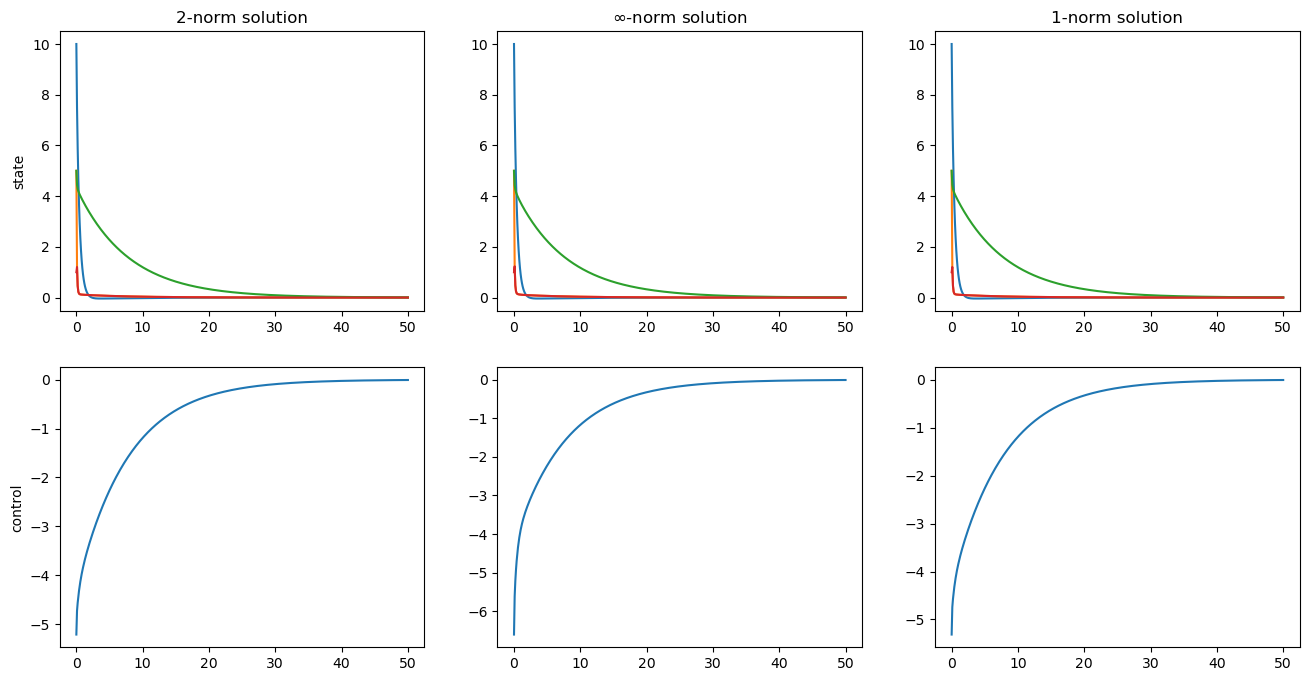

In [7]:

def test_LQR(A_hat, B_hat, Q = None, R = None):
  Q = np.identity(A.shape[0]) if Q is None else Q
  R = np.identity(B.shape[1]) if R is None else R
  
  # Define a Linear system
  sys = LinearSystem(A, B, C, D, time_period = 0.1)
  sys_hat = LinearSystem(A_hat, B_hat, C, D, time_period = 0.1)

  builder = DiagramBuilder()
  plant = builder.AddSystem(sys)

  controller = builder.AddSystem(LinearQuadraticRegulator(sys_hat, Q, R))

  builder.Connect(controller.get_output_port(), plant.get_input_port())
  builder.Connect(plant.get_output_port(), controller.get_input_port())

  logger = LogVectorOutput(plant.get_output_port(), builder)
  logger_ctrl = LogVectorOutput(controller.get_output_port(), builder)

  diagram = builder.Build()
  simulator = Simulator(diagram)
  context = simulator.get_mutable_context()
  context.SetDiscreteState(0,[10.,5.,5.,1.])

  simulator.AdvanceTo(50)

  log = logger.FindLog(context)
  log_ctrl = logger_ctrl.FindLog(context)
  t = log.sample_times()
  U = log_ctrl.data()
  X = log.data()

  return t, U, X

t, U_2norm, X_2norm = test_LQR(Ahat_2norm, Bhat_2norm)
t, U_infnorm, X_infnorm = test_LQR(Ahat_infnorm, Bhat_infnorm)
t, U_1norm, X_1norm = test_LQR(Ahat_1norm, Bhat_1norm)

fig, ax = plt.subplots(2, 3, figsize=(16, 8))
ax[0,0].plot(t, X_2norm.T)
ax[1,0].plot(t, U_2norm.T)
ax[0,1].plot(t, X_infnorm.T)
ax[1,1].plot(t, U_infnorm.T)
ax[0,2].plot(t, X_1norm.T)
ax[1,2].plot(t, U_1norm.T)
ax[0,0].set_ylabel("state")
ax[1,0].set_ylabel("control")
ax[0,0].set_title("2-norm solution")
ax[0,1].set_title("$\infty$-norm solution")
ax[0,2].set_title("1-norm solution")
plt.show()


You can also test the model with increased noise in the data. You can play around with different values of 'noise_level' to vary the intensity of the noise in the measurement.

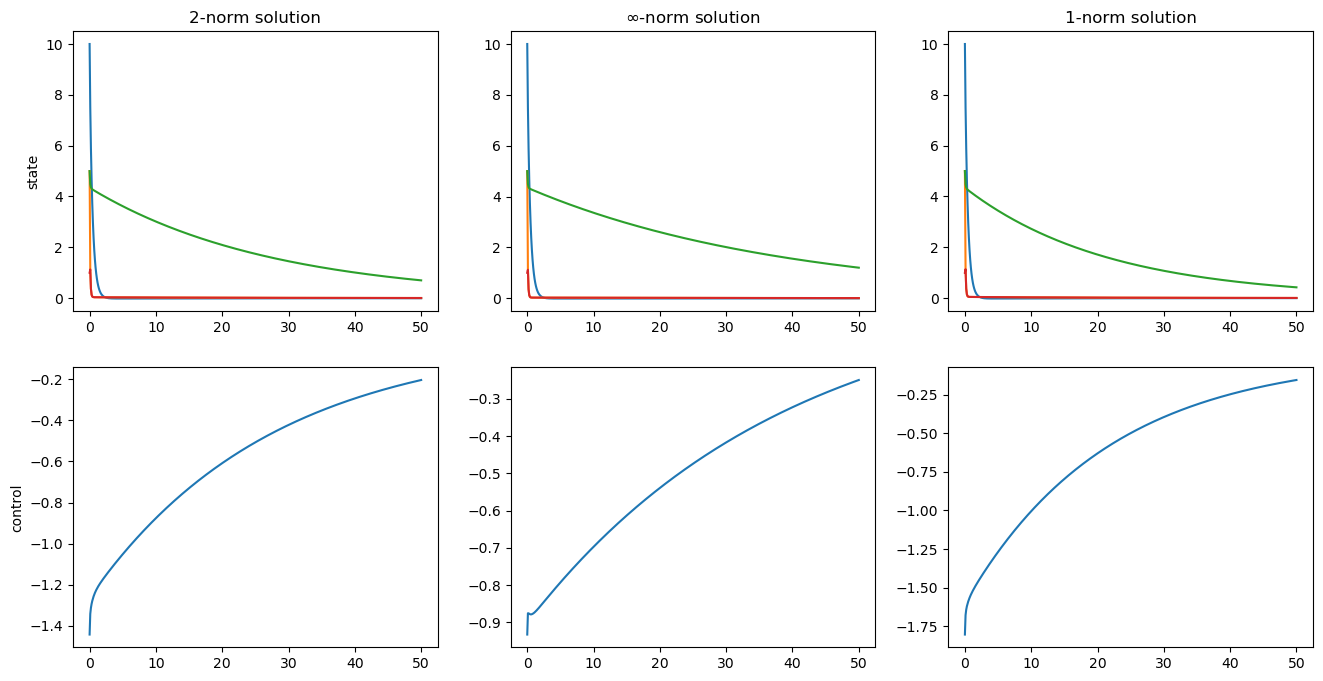

In [11]:
t, U_noisy, X_noisy = generate_data(A, B, C, D, noise_level = 0.5)

Ahat_noisy_2norm, Bhat_noisy_2norm = sysid_2norm(X_noisy, U_noisy)
t, U_2norm, X_2norm = test_LQR(Ahat_noisy_2norm, Bhat_noisy_2norm)

Ahat_noisy_infnorm, Bhat_noisy_infnorm, obj_infnorm_noisy = sysid_infnorm(X_noisy, U_noisy)
t, U_infnorm, X_infnorm = test_LQR(Ahat_noisy_infnorm, Bhat_noisy_infnorm)

Ahat_noisy_1norm, Bhat_noisy_1norm, obj_1norm_noisy = sysid_1norm(X_noisy, U_noisy)
t, U_1norm, X_1norm = test_LQR(Ahat_noisy_1norm, Bhat_noisy_1norm)

fig, ax = plt.subplots(2, 3, figsize=(16, 8))
ax[0,0].plot(t, X_2norm.T)
ax[1,0].plot(t, U_2norm.T)
ax[0,1].plot(t, X_infnorm.T)
ax[1,1].plot(t, U_infnorm.T)
ax[0,2].plot(t, X_1norm.T)
ax[1,2].plot(t, U_1norm.T)
ax[0,0].set_ylabel("state")
ax[1,0].set_ylabel("control")
ax[0,0].set_title("2-norm solution")
ax[0,1].set_title("$\infty$-norm solution")
ax[0,2].set_title("1-norm solution")
plt.show()


## Autograding
You can check your work by running the following cell:

In [9]:
from underactuated.exercises.sysid.test_linear_sysid import TestLinearSysid
from underactuated.exercises.grader import Grader
Grader.grade_output([TestLinearSysid], [locals()], 'results.json')
Grader.print_test_results('results.json')


Total score is 9/9.

Score for Test L1 regression is 3/3.

Score for Test L2 regression is 3/3.

Score for Test L infinite regression is 3/3.


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=fc6e46c8-492d-4175-8d63-6a96a379eb44' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>